# Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2018, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

This final project explores the best locations for Thai restaurants throughout the city of New York. As New York is the most diverse city in the world (800 languages are spoken in New York), it has a long tradition of different ethnical restaurants. Now when the idea of a healthy lifestyle conquered the minds of people all over the country, Thai restaurants became extremely popular, as they offer a healthy alternative to regular American eating habits. That's why Potentially the owner of the new East European restaurant can have great success and consistent profit. However, as with any business, opening a new restaurant requires serious considerations and is more complicated than it seems from the first glance. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. So our project will attempt to answer the questions “Where should the investor open a Thai Restaurant?” and “Where should I go If I want great Thai food?

# Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

# Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Thai restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

# Problem Statement

1. What is / are the best location(s) for Thai cuisine in New York City?
2. In what Neighborhood and/or borough should the investor open a Thai restaurant to have the best chance of being successful?
3. Where would I go in New York City to have the best Thai food?

### Before we get the data and start exploring it, let's import all required libraries 

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

### Now let's define the functions we are going to use later in this project

In [7]:
CLIENT_ID = 'EXWJUTUW4RA54UYYLFORVTMGI0XJ4HOGNDOF2WWPCVQEROQI' # your Foursquare ID
CLIENT_SECRET = 'NYV1H0SQ3OEWNBBRNQFOFY4QIKPVKULSDP5O0PPDWQXTTWUP' # your Foursquare Secret
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EXWJUTUW4RA54UYYLFORVTMGI0XJ4HOGNDOF2WWPCVQEROQI
CLIENT_SECRET:NYV1H0SQ3OEWNBBRNQFOFY4QIKPVKULSDP5O0PPDWQXTTWUP


In [54]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [8]:
def get_venues(lat,lng):
    #set variables
    radius=300
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now let's use the above codes to get our initial NYC data

In [11]:
# get new york data
new_york_data=get_new_york_data()

In [12]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York.

### Initial Data Analysis

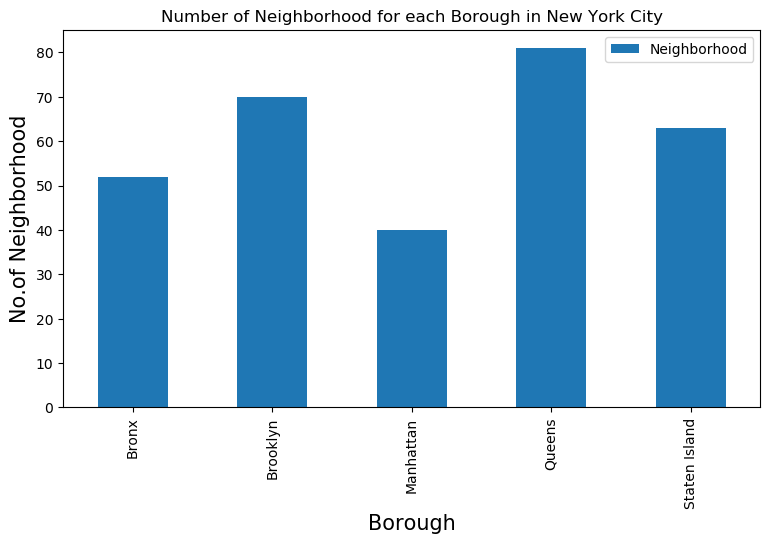

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Let's analyze further and see how many Thai restaurants there are in each neighborhood and borough. After it, graph the results.

In [15]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(new_york_data),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(Thai_resturants)))
    for resturant_detail in Thai_resturants.values.tolist():
        id, name , category=resturant_detail
        Thai_rest_ny = Thai_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Thai Resturants in Wakefield, Bronx:0
( 2 / 306 ) Thai Resturants in Co-op City, Bronx:0
( 3 / 306 ) Thai Resturants in Eastchester, Bronx:0
( 4 / 306 ) Thai Resturants in Fieldston, Bronx:0
( 5 / 306 ) Thai Resturants in Riverdale, Bronx:0
( 6 / 306 ) Thai Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Thai Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Thai Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Thai Resturants in Norwood, Bronx:0
( 10 / 306 ) Thai Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Thai Resturants in Baychester, Bronx:0
( 12 / 306 ) Thai Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Thai Resturants in City Island, Bronx:0
( 14 / 306 ) Thai Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Thai Resturants in University Heights, Bronx:0
( 16 / 306 ) Thai Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Thai Resturants in Fordham, Bronx:0
( 18 / 306 ) Thai Resturants in East Tremont, Bronx:0
( 19 / 306 ) Thai Resturants in West Farms, Bronx:0


In [16]:
#Thai_rest_ny.to_csv('Thai_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
Thai_rest_ny.to_csv('Thai_rest_ny_tocsv1.csv')

In [17]:
Thai_ny = pd.read_csv('Thai_rest_ny_tocsv1.csv')
Thai_rest_ny.tail()

,Borough,Neighborhood,ID,Name
34,Queens,Hunters Point,49cfd074f964a520ce5a1fe3,Tuk Tuk
35,Manhattan,Turtle Bay,548cb1a2498e7cd8fd9f98ce,Herbs Thai Bistro
36,Manhattan,Flatiron,57e83df3498eebbe238cb36f,Thai Villa
37,Manhattan,Flatiron,5c82ac6951950e0039187d89,Nana Thai Street
38,Queens,Sunnyside Gardens,4bf5e3f05e800f472e80e6d4,I Am Thai Restaurant


In [18]:
Thai_rest_ny.shape

(39, 4)

We got 39 Thai Restaurants across the New York City.

As we continue our analysis, we see below that although Queens had the least number of neighborhoods, it does have the highest number of Thai restaurants. The borough of Brooklyn has the highest number of Thai restaurants in all of NYC.

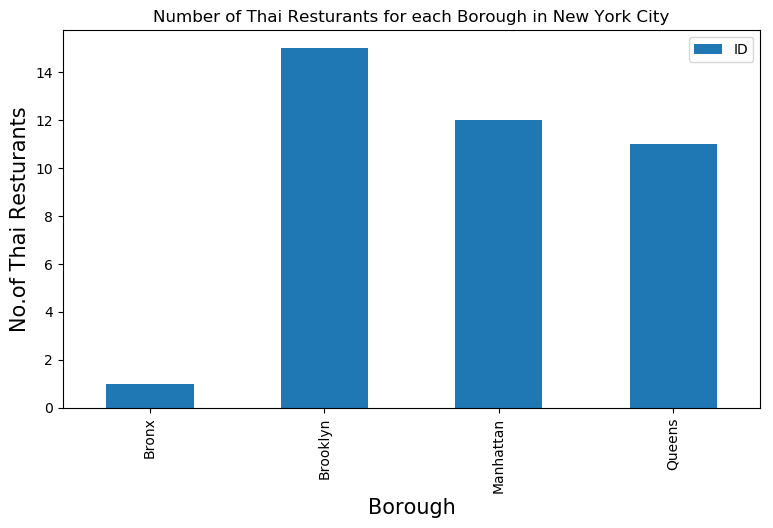

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
Thai_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

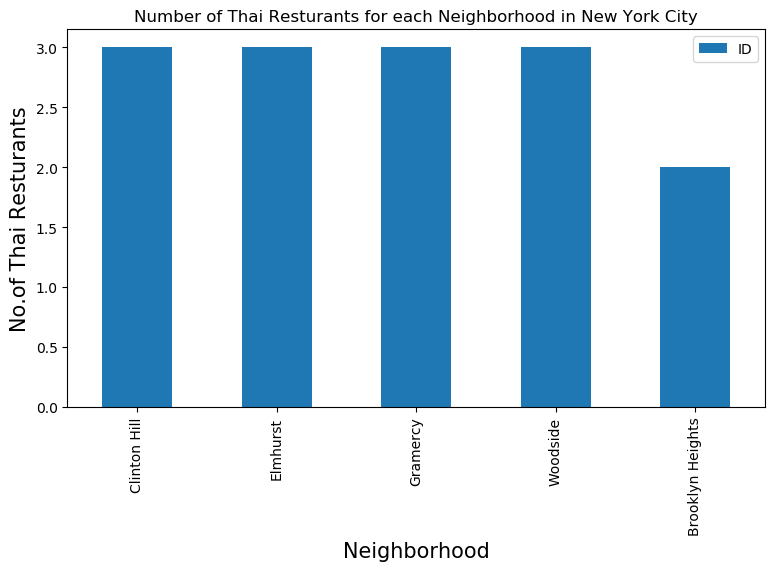

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Thai Resturants', fontsize=15)
#giving a bar plot
Thai_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:
Thai_rest_ny[Thai_rest_ny['Neighborhood']=='Clinton Hill']

,Borough,Neighborhood,ID,Name
8,Brooklyn,Clinton Hill,4a7b3439f964a5204cea1fe3,Myrtle Thai
9,Brooklyn,Clinton Hill,4a709d9ff964a520f6d71fe3,Thai 101
10,Brooklyn,Clinton Hill,54ea1fc3498e51bac940c79e,Thaiholic


In [23]:
Thai_rest_ny[Thai_rest_ny['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
28,Queens,Elmhurst,52f693e6498ed9d2a3fbad75,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...
29,Queens,Elmhurst,5abad6379de23b5eeb077b04,Lamoon
30,Queens,Elmhurst,53d53756498e2a83f3c2aadb,Paet Rio


In [24]:
Thai_rest_ny[Thai_rest_ny['Neighborhood']=='Gramercy']

,Borough,Neighborhood,ID,Name
21,Manhattan,Gramercy,5bc928d73c858d002cec4564,Mi Noodle Bar
22,Manhattan,Gramercy,4cb0d96a562d224b35281a88,Bangkok 2 Thai
23,Manhattan,Gramercy,5a89c0ca9e0d5409e0a99f49,Proong Noodle Bar


In [25]:
Thai_rest_ny[Thai_rest_ny['Neighborhood']=='Woodside']

,Borough,Neighborhood,ID,Name
24,Queens,Woodside,3fd66200f964a5204ef11ee3,SriPraPhai
25,Queens,Woodside,4a7f6626f964a520e8f31fe3,Thailand's Center Point
26,Queens,Woodside,4bedd3e8a40fc928d193820c,Sweet Basil Thai


So in the top 4 neighbourhoods with Thai restaurants, 2 are in Queens, although Brooklyn has the highest number of Thai restauarant.

Now we will get the ranking of each restaurant for further analysis.

In [26]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Thai_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Thai_rest_ny),')','processed')
    Thai_rest_stats_ny = Thai_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5f9f9152dd96685c64efd635'}, 'response': {'venue': {'id': '4a739e29f964a520f5dc1fe3', 'name': 'Siam Square', 'contact': {'phone': '7184328200', 'formattedPhone': '(718) 432-8200'}, 'location': {'address': '564 Kappock St', 'lat': 40.8787962348852, 'lng': -73.91670090763066, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8787962348852, 'lng': -73.91670090763066}, {'label': 'entrance', 'lat': 40.878772, 'lng': -73.916958}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['564 Kappock St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/siam-square/4a739e29f964a520f5dc1fe3', 'categories': [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount':

In [27]:
Thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square,15,7.1,13
1,Brooklyn,Bay Ridge,0,0,0,0.0,0
2,Brooklyn,Kensington,4b36a0f5f964a5207b3925e3,To Be Thai,18,7.7,16
3,Brooklyn,Prospect Heights,57117904498eea6297e41d0a,Muse,44,8.1,7
4,Brooklyn,Brooklyn Heights,476f8da1f964a520044d1fe3,Lantern Thai Kitchen,155,8.0,73


In [28]:
Thai_rest_stats_ny.shape

(39, 7)

In [29]:
Thai_rest_ny.shape

(39, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [30]:
Thai_rest_stats_ny.to_csv('Thai_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [31]:
Thai_rest_stats_ny_csv=pd.read_csv('Thai_rest_stats_ny.csv')

In [32]:
Thai_rest_stats_ny_csv.shape

(39, 7)

In [33]:
Thai_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square,15,7.1,13
1,Brooklyn,Bay Ridge,0,0,0,0.0,0
2,Brooklyn,Kensington,4b36a0f5f964a5207b3925e3,To Be Thai,18,7.7,16
3,Brooklyn,Prospect Heights,57117904498eea6297e41d0a,Muse,44,8.1,7
4,Brooklyn,Brooklyn Heights,476f8da1f964a520044d1fe3,Lantern Thai Kitchen,155,8.0,73


In [34]:
Thai_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null object
Rating          39 non-null float64
Tips            39 non-null object
dtypes: float64(1), object(6)
memory usage: 2.2+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [35]:
Thai_rest_stats_ny['Likes']=Thai_rest_stats_ny['Likes'].astype('float64')

In [36]:
Thai_rest_stats_ny['Tips']=Thai_rest_stats_ny['Tips'].astype('float64')

In [37]:
Thai_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
Borough         39 non-null object
Neighborhood    39 non-null object
ID              39 non-null object
Name            39 non-null object
Likes           39 non-null float64
Rating          39 non-null float64
Tips            39 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.2+ KB


Now the data types looks correct

In [38]:
# Resturant with maximum Likes
Thai_rest_stats_ny.iloc[Thai_rest_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                768
Rating                               8.9
Tips                                 358
Name: 24, dtype: object

In [39]:
# Resturant with maximum Tips
Thai_rest_stats_ny.iloc[Thai_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                768
Rating                               8.9
Tips                                 358
Name: 24, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [40]:
ny_neighborhood_stats=Thai_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [41]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
14,Lenox Hill,9.200000
9,Flatiron,8.900000
18,Red Hook,8.600000
11,Hunters Point,8.600000
15,Little Italy,8.550000
20,South Side,8.500000
12,Jackson Heights,8.400000
3,Clinton Hill,8.266667
8,Elmhurst,8.266667
5,Downtown,8.250000


Above are the top neighborhoods with top average rating of Thai resturants

In [42]:
ny_borough_stats=Thai_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [43]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.066667
1,Brooklyn,7.340000
3,Queens,7.327273
0,Bronx,7.100000


Similarly these are the average rating of Thai Resturants for each Borough

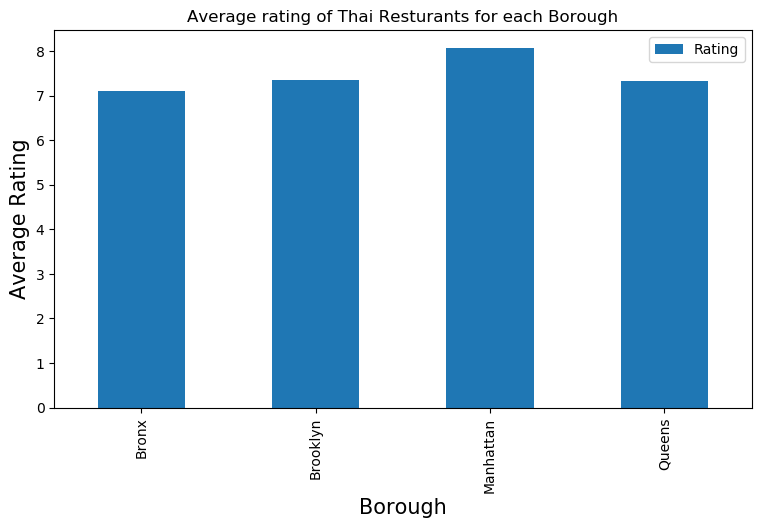

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Thai Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Thai_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

So the average highest rating is in Manhattan.

We will consider all the neighborhoods with average rating greater or equal 8.5 to visualize on map

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [46]:
ny_neighborhood_stats

,Neighborhood,Average Rating
9,Flatiron,8.90
11,Hunters Point,8.60
14,Lenox Hill,9.20
15,Little Italy,8.55
18,Red Hook,8.60
20,South Side,8.50


We will join this dataset to original new york data to get lonitude and latitude

In [47]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [48]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [49]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Flatiron,40.739673,-73.990947,8.90
1,Queens,Hunters Point,40.743414,-73.953868,8.60
2,Manhattan,Lenox Hill,40.768113,-73.958860,9.20
3,Manhattan,Little Italy,40.719324,-73.997305,8.55
4,Brooklyn,Red Hook,40.676253,-74.012759,8.60
5,Brooklyn,South Side,40.710861,-73.958001,8.50


In [55]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [56]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [57]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [58]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Conclusion

Brooklyn has the highest number of Thai restaurant, and the average rating is above medium, which is more for casual meals.

Manhattan has the top average rating of Thai cuisine, and is highly recommended if you prefer Thai Cuisine.

Lenox Hill ranks top1 in rating of Thai Resturants in NYC.